# GFA ETC Pipline

A basic example of loading GFA raw data, applying calibrations and estimating dark current using the online ETC pipeline.

You will need to use a python environment that includes numpy, scipy, matplotlib and fitsio. For example, at NERSC use:
```
source /project/projectdirs/desi/software/desi_environment.sh master
```
If you are running on the NERSC jupyterhub you can select the `DESI master` kernel.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys
from pathlib import Path

### NERSC Environment

Check that we are running at NERSC and specify where to find data. In a different environment, set the corresponding `ROOT` by hand below:

In [4]:
assert os.getenv('NERSC_HOST', False)

In [5]:
ROOT = Path('/project/projectdirs/desi/spectro/data/')
assert ROOT.exists()

### GFA Calibration Data

The GFA calibration data is contained in a single ~180Mb FITS file.  You can download the latest version from svn using:
```
svn --username <trac-user-name> co https://desi.lbl.gov/svn/calib/desi_gfa_calib/trunk calib
```
Alternatively, if you are running at NERSC, you can refer to this version in `$DESI_ROOT/cms/gfa/calib/`:

In [6]:
CALIB = Path('/global/project/projectdirs/desi/cmx/gfa/calib/GFA_calib.fits')
assert CALIB.exists()

### ETC Pipeline Software

The easiest way to use the calibration data is via the ETC pipeline code in the [desietcimg](https://github.com/dkirkby/desietcimg) package.

You can install this from the command line into your current conda environment using:
```
pip install --user git+https://github.com/dkirkby/desietcimg
```
You can also install it directly from this notebook by uncommenting the last line in the cell below:

In [7]:
def install_pipeline(upgrade=False):
    try:
        import desietcimg
        installed = True
    except ImportError:
        installed = False
    if not upgrade:
        print('desietcimg is already installed and upgrade is False')
    else:
        !{sys.executable} -m pip install --upgrade --user git+https://github.com/dkirkby/desietcimg
    
#install_pipeline(upgrade=True)

Import the pipeline modules used below:

In [8]:
from desietcimg.util import load_raw, downsample
from desietcimg.plot import plot_pixels, plot_data
from desietcimg.gfa import GFACamera

### Example: GFA Science Exposure

Specify the exposure to process:

In [9]:
night, expid = '20191026', '00021619'

Lookup the corresponding directory:

In [10]:
path = ROOT / night / expid
assert path.exists()

Load the raw data and selected metadata for a specific camera:

In [11]:
camera = 'FOCUS1'
%time raw, meta = load_raw(path / f'gfa-{expid}.fits.fz', 'MJD-OBS', 'EXPTIME', 'GCCDTEMP', hdu=camera)

CPU times: user 43.4 ms, sys: 13.2 ms, total: 56.6 ms
Wall time: 176 ms


Examine the metadata, which is a per-exposure array for each FITS header keyword:

In [12]:
exptime = meta['EXPTIME']
ccdtemp = meta['GCCDTEMP']
print(f'Exposure time is {exptime[0]}s at T={ccdtemp[0]}C')

Exposure time is 60.0s at T=11.915C


The returned raw data is a 3D array indexed by exposure number (only 1 in this example), row (y) and column (x):

In [13]:
raw.shape

(1, 1032, 2248)

The raw data includes pre- and post-overscan regions:

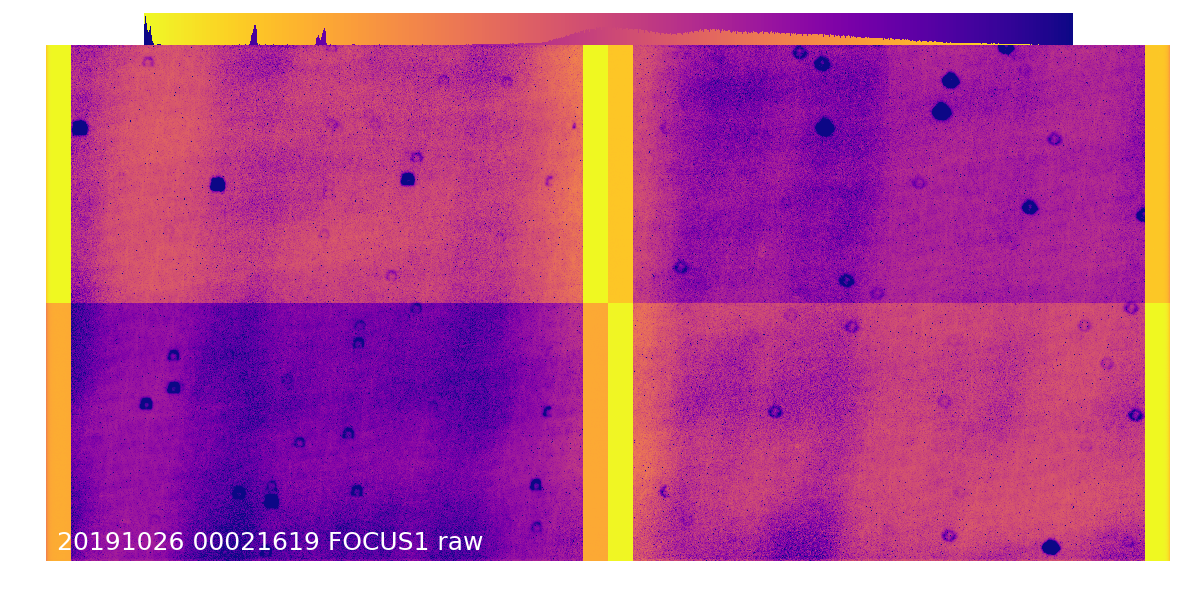

In [14]:
downsampled_raw = downsample(raw[0], 2)
vmin, vmax = np.percentile(downsampled_raw, (1, 99))
label = f'{night} {expid} {camera}'
plot_pixels(downsampled_raw, label=label + ' raw', colorhist=True, imshow_args=dict(vmin=vmin, vmax=vmax));

Subtract bias, apply gains and calculate inverse-variance weights using the `GFACamera` class (which only needs to be created once):

In [15]:
GFA = GFACamera(calib_name=str(CALIB))

Use the `setraw` method to perform the default processing:

In [16]:
%time GFA.setraw(raw, name=camera)

CPU times: user 58.4 ms, sys: 3.97 ms, total: 62.4 ms
Wall time: 61 ms


The `GFA` object now contains arrays of calibrated data (in electrons with overscan regions removed) and corresponding ivars (with bad pixel ivars set to zero):

In [17]:
GFA.data.shape, GFA.ivar.shape

((1, 1032, 2048), (1, 1032, 2048))

Estimate and subtract the dark current (for all exposures if several are loaded):

In [18]:
dark = GFA.get_dark_current(ccdtemp, exptime)

The `plot_data` method automatically calculates the pixel range to display (using the median ivar) and shows any masked pixels (ivar==0) in cyan:

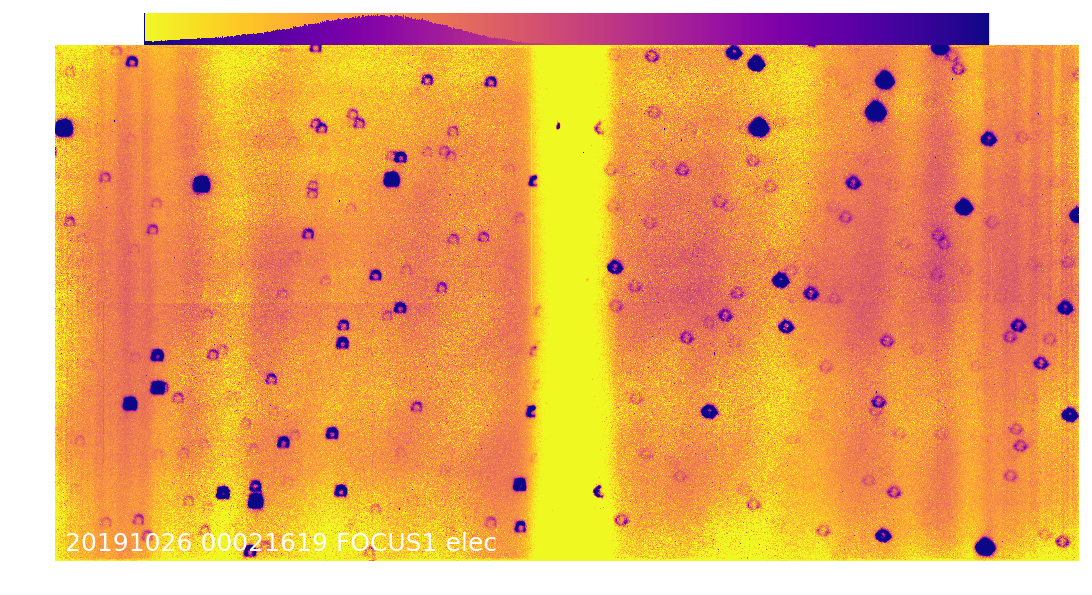

In [19]:
plot_data(GFA.data[0] - dark[0], GFA.ivar[0], downsampling=2, label=label + ' elec', colorhist=True);